In [14]:
from settings import *
from q_channel_approx.physics_defns import default_jump_operators, no_decay_jump_operators
from q_channel_approx import TriangularLayoutA, HEA_fac

##### Set global constants for this experiment

In [15]:
delta_t = 0.01
N = 4
L = 100


##### Load observables

In [16]:
Os = all_observables(m=m)
jump_oper_decay = default_jump_operators(m=m, gammas=gammas)
jump_oper_no_decay = no_decay_jump_operators()

##### Make training data

In [17]:
rho0s = random_rho0s(m=m, L=L)
rhoss, ts = solve_lindblad_rho0s(rho0s=rho0s, delta_t=delta_t, N=N, s=system, jump_opers=jump_oper_decay)
training_data = mk_training_data(rhoss=rhoss, Os=Os)

random_rho0s: setting seed=56605


##### Create a qubit layout and a parametrized circuit on those qubits

In [18]:
qubits = TriangularLayoutA(m=m, distance=0.9)
circuit = HEA_fac(qubits, depth=10, repeats=1)

<Axes: title={'center': 'Qubit layout'}>

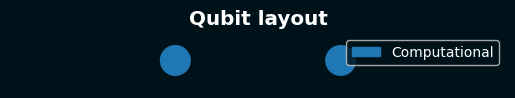

In [19]:
qubits.show_layout()

In [20]:
# optionally load already optimized theta

# theta_opt = np.load("ham_theta_opt.npy")

##### Optimize the parameters

In [21]:
theta_opt, errors, thetas = optimize(
    circuit=circuit, 
    training_data=training_data, 
    n_grad=10, 
    max_count=500,
)

# optionally, save the results of the optimization process

theta_opt = np.save("ham_theta_opt.npy", theta_opt)
thetas = np.save("ham_thetas.npy", thetas)
errors = np.save("ham_errors.npy", errors)

optimizer (optimization indices): setting seed=30588
-----
        Grad calculation time: 
        176.0971541404724 
        Armijo calculation time: 
        13.717771768569946 
        Total grad descend time: 
        3:9.81


In [22]:
theta_opt = np.load("ham_theta_opt.npy")
thetas = np.load("ham_thetas.npy")
errors = np.load("ham_errors.npy")

Text(0, 0.5, '$Error$')

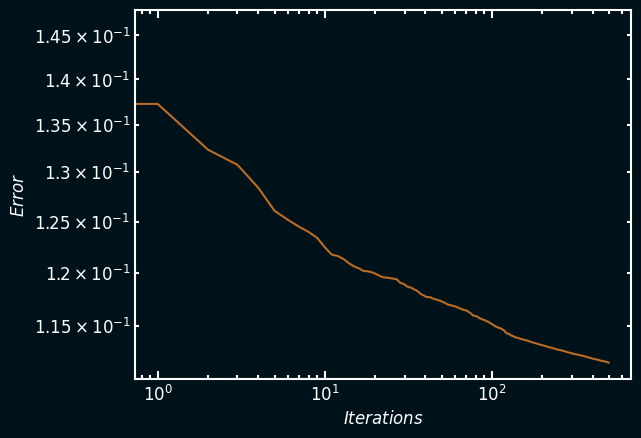

In [23]:
plt.loglog(errors)
plt.xlabel("$Iterations$")
plt.ylabel("$Error$")

##### Plot approximated solution compared to reference solution

In [24]:
n_time_steps = 20

rho0 = rho_rand_haar(m=m)

Os_comp = [O.full() for O in create_observables_comp_basis(m=m)]

rho_rand_haar: seed=94152


In [25]:
# calculate reference solution

rhos_ref, ts = solve_lindblad_rho0(rho0, 
                                delta_t=delta_t, 
                                N=n_time_steps, 
                                s=system, 
                                jump_opers=jump_oper_decay,
                                )
Ess_ref = measure_rhos([r.full() for r in rhos_ref], Os_comp)

# calculate approximated solution

evolver = evolver_fac(circuit, theta_opt)
rhos_approx = evolver(n=n_time_steps, rho=rho0.full())
Ess_approx = measure_rhos(rhos_approx, Os_comp)

c:\Users\Admin\Desktop\BFP\quantum-channel-approximation\venv\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Admin\Desktop\BFP\quantum-channel-approximation\venv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


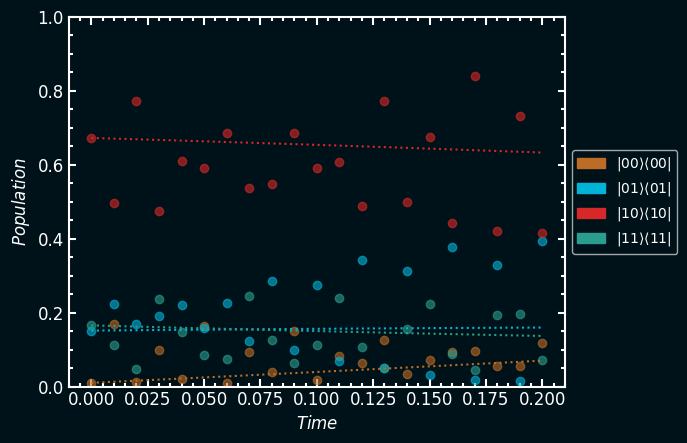

In [35]:
plot_approx(ts, Ess_approx)
plot_ref(ts, Ess_ref)
from matplotlib.patches import Patch

# some formatting to make plot look nice
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
legend_items = [Patch(color=colors[j], label=rf"$|{format(j, f'0{m}b')}\rangle \langle{format(j, f'0{m}b')}|$") for j in range(2**m)]

plt.ylabel("$Population$")
plt.xlabel("$Time$")
plt.ylim(0, 1)
plt.gca().legend(handles=legend_items, loc="center left", bbox_to_anchor=(1, 0.5))